# XAI for exploratory analysis

In [1]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset()

result_data = dataset.get(result_data)


In [2]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

individuals_using_the_internet_percent_of_population
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
area
education_years
services_value_added_percent_of_gdp
manufacturing_value_added_percent_of_gdp
net_official_development_assistance_received_current_usd
total_population
economic_activity
life_expectancy_at_birth_total_years
gdp_per_person_employed_constant_2011_ppp_usd
population_size
petroleum_energy_production
renewables_excluding_hydro_share
energy_use_kg_of_oil_equivalent_per_capita
hydro_electric_energy_production
gas_energy_production
coal_energy_production
consumer_price_index_change
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [3]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



In [4]:
from src.clean.input import input_regression_by_group

# dataset = result_data.ml_ready
# imputed  = input_regression_by_group(dataset)
# print("Missing after imputation:", imputed.isna().sum().sum())  # should be 0

imputed_path = "data/02--ml-ready/imputed.csv"
# imputed.to_csv(imputed_path)
imputed = pd.read_csv(imputed_path, index_col=0)

print(imputed.to_markdown())


|      | date       | country                       |   individuals_using_the_internet_percent_of_population |   net_trade_in_goods_and_services_current_usd |   fdi_net_inflows_current_usd |             area |   education_years |   services_value_added_percent_of_gdp |   manufacturing_value_added_percent_of_gdp |   net_official_development_assistance_received_current_usd |   total_population |   economic_activity |   life_expectancy_at_birth_total_years |   gdp_per_person_employed_constant_2011_ppp_usd |   population_size |   petroleum_energy_production |   renewables_excluding_hydro_share |   energy_use_kg_of_oil_equivalent_per_capita |   hydro_electric_energy_production |   gas_energy_production |   coal_energy_production |   consumer_price_index_change |   unemployment_rate_percent_of_total_labor_force |   gdp_current_usd |
|-----:|:-----------|:------------------------------|-------------------------------------------------------:|----------------------------------------------:|---

In [5]:
from sklearn.preprocessing import StandardScaler
from src.preprocess.forecast_dataset import ForecastConfig, ForecastDataset
from src.model.train_forecast import train_forecast

import pandas as pd

lengths = imputed.groupby('country').size().sort_values()
print(lengths.describe())
print(lengths.head(10))   # the 10 smallest
print(lengths.tail(10))   # the 10 largest


# 1) pick numeric features & label
label_col = "gdp_current_usd"
num_cols  = imputed.select_dtypes(include="number").columns.tolist()
feat_cols = [c for c in num_cols if c != label_col]

# 2) fit two scalers:
#  - panel_scaler on feat_cols only
panel_scaler = StandardScaler().fit(imputed[feat_cols].values)
#  - window_scaler on feat_cols+label_col
window_scaler = StandardScaler().fit(
    imputed[feat_cols + [label_col]].values
)

# 3) build config
cfg = ForecastConfig(
    window_size   = 30,
    horizon       = 1,
    feat_cols     = feat_cols,
    label_col     = label_col,
    group_col     = "country",
    date_col      = "date",
    val_frac      = 0.1,
    test_frac     = 0.1,
    batch_size    = 64,
    panel_scaler  = panel_scaler,
    window_scaler = window_scaler,
)


# PANEL loader for SHAP ([B, C, F])
panel_loader = ForecastDataset.make_panel_loader(imputed, cfg)

# SLIDING-WINDOW loaders for LSTM forecasting
train_loader, val_loader, test_loader = ForecastDataset.make_sliding_loaders(imputed, cfg)

(
    model, 
    (train_loader, val_loader, test_loader)
) = train_forecast(
    train_loader=train_loader, 
    val_loader=val_loader, 
    test_loader=test_loader,
    feat_cols=feat_cols,
    label_col=label_col,
    window_size = 30,
    horizon     =  1,
    val_frac    = 0.1,
    test_frac   = 0.1,
    batch_size  = 64,
    max_epochs  = 10000,
    patience    = 30,
    lr          = 1e-4
)

count    219.0
mean      34.0
std        0.0
min       34.0
25%       34.0
50%       34.0
75%       34.0
max       34.0
dtype: float64
country
afghanistan            34
albania                34
algeria                34
american_samoa         34
andorra                34
angola                 34
antigua_and_barbuda    34
argentina              34
armenia                34
aruba                  34
dtype: int64
country
uruguay               34
uzbekistan            34
vanuatu               34
venezuela             34
vietnam               34
virgin_islands_us     34
west_bank_and_gaza    34
yemen                 34
zambia                34
zimbabwe              34
dtype: int64


2025-05-15 02:51:36,277 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 1/10000 train=1.6819 val=10.0470
2025-05-15 02:51:36,462 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 2/10000 train=1.6683 val=10.0048
2025-05-15 02:51:36,647 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 3/10000 train=1.6543 val=9.9605
2025-05-15 02:51:36,832 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 4/10000 train=1.6359 val=9.9172
2025-05-15 02:51:37,017 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 5/10000 train=1.6226 val=9.8651
2025-05-15 02:51:37,204 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 6/10000 train=1.6052 val=9.8097
2025-05-15 02:51:37,388 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 7/10000 train=1.5883 val=9.7430
2025-05-15 02:51:37,580 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 8/10000 train=1.5658 val=9.6710
2025-05-15 02:51:37,774 - [train_forecast.] - 

/tmp/ipykernel_118103/3388247518.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


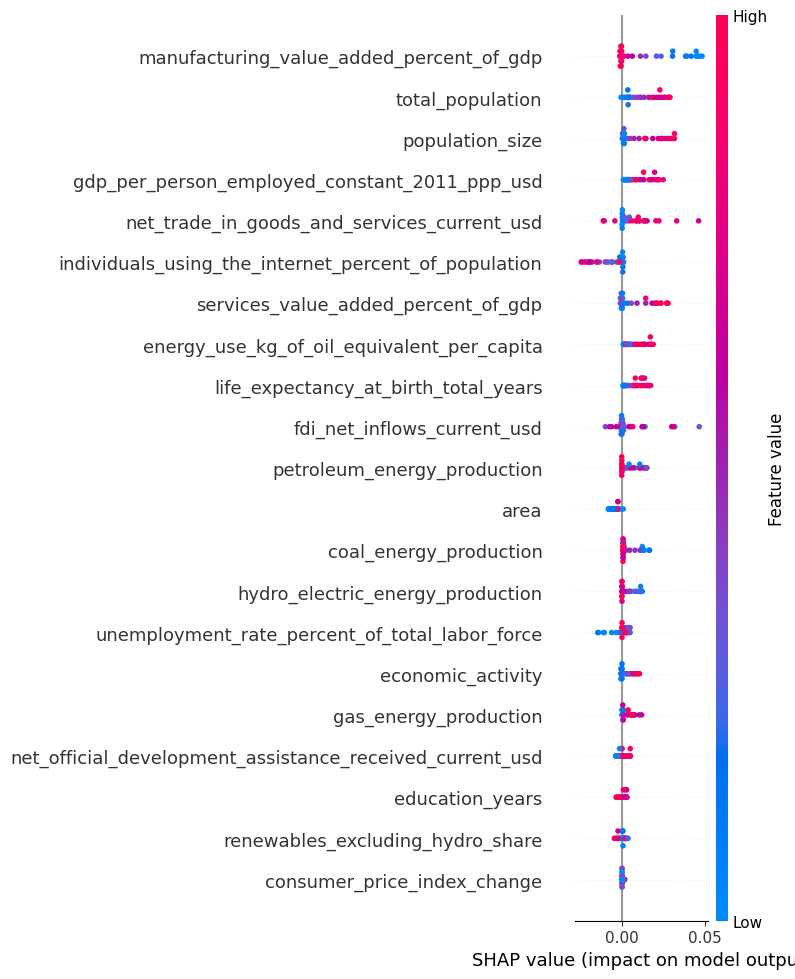

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # CPU-only

import shap
import numpy as np
import matplotlib.pyplot as plt

model.cpu().eval()

# ── 1) Build the GradientExplainer using a background batch ─────────
bg_X, _ = next(iter(train_loader))    # shape: (B, time, F)
bg_X = bg_X.detach().cpu()
explainer = shap.GradientExplainer(model, bg_X)

# ── 2) Grab one test batch ─────────────────────────────────────────
Xs, _ = next(iter(test_loader))       # shape: (B, time, F)
Xs = Xs.detach().cpu()

# ── 3) Compute SHAP values ──────────────────────────────────────────
# returns a list (one entry per model output); take the first
s3d = explainer.shap_values(Xs)[0]    # shape: (time, F, 1)
# drop the trailing singleton dim if present
s3d = np.squeeze(s3d, axis=-1)        # shape: (time, F)

# ── 4) Build 2-D SHAP matrix: treat each time-step as a “sample” ───
s2d = s3d                             # shape: (time, F)

# ── 5) Build matching feature matrix: mean over the batch dim ──────
X_2d = Xs.mean(dim=0).numpy()         # shape: (time, F)

# ── 6) Sanity check ─────────────────────────────────────────────────
assert s2d.shape == X_2d.shape == (Xs.shape[1], len(feat_cols)), (
    f"shapes mismatch: s2d={s2d.shape}, X_2d={X_2d.shape}, #feat_cols={len(feat_cols)}"
)

# ── 7) Plot beeswarm of every feature (one point per time-step) ────
plt.figure(figsize=(14, 0.35 * len(feat_cols) + 2))
shap.summary_plot(
    s2d,
    X_2d,
    feature_names=feat_cols,
    plot_type="dot",
    max_display=len(feat_cols),
    show=False
)
plt.tight_layout()
plt.show()
